In [ ]:
#from spaotsc import SpaOTsc
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial import distance_matrix
from matplotlib import colors as mcolors
from scipy.spatial.distance import cdist
from sklearn.neighbors import KernelDensity
from sklearn.cluster import MeanShift, KMeans,DBSCAN
from sklearn.cluster import KMeans
#from pyclustering.cluster.gmeans import gmeans
from itertools import cycle
#from shapely.geometry import Polygon
from sklearn.metrics.cluster import adjusted_rand_score
#import ot
import math
from scipy.stats import ranksums,spearmanr
from scipy.optimize import curve_fit
from statsmodels.stats.multitest import multipletests
import warnings

import bezier
from matplotlib.collections import LineCollection,PathCollection
import itertools
#from forest_fire_clustering.forest_fire_clustering import FFC
from collections import Counter
import scipy.stats as st
from sklearn.metrics import pairwise_distances
from random import shuffle
from scipy.stats import entropy
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
import sys

In [1]:
import sys
#insert the directory of dbscan_ot module
sys.path.insert(0, '/data/hemberg/jingyi/project/1.pdac/scripts/dbscan_ot_py')

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance_matrix
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
import imp
imp.reload(dbscan_ot)
import warnings
warnings.filterwarnings("ignore")

In [3]:
#your worksapce
datap = '/data/hemberg/jingyi/project/1.pdac/scripts/dbscan_ot_py/'

In [72]:
def read_data(file):
    try:
        df = pd.read_csv(file, header = 0, index_col=None, sep = "\t")
    except:
        df = pd.DataFrame()
    return df

In [244]:
#load input: metatable, count matrix, ligand-receptor pairs
#metabale should includes cell_id, fov_id, annotation, and coordinates
group = 'mut'
#group = 'wt'
meta_df = pd.read_csv(datap+'example/'+group+'_meta_data.txt',sep='\t',index_col=None)
print(meta_df.head())

#count matix
exp_df = pd.read_csv(datap+'example/'+group+'_exp_matrix.txt',sep='\t',index_col=None)
print(exp_df.head())

#LR pairs
known_lr_pairs = pd.read_csv(datap+'example/lr_gene.list', sep = '\t', header = None, index_col = None)
known_lr_pairs.columns = ['l_gene','r_gene']
print(known_lr_pairs.head())

   cell_id  fov    annotation  x_positions  y_positions
0       32    0     Erythroid     5.430265    78.970097
1       33    0     Erythroid     4.793709    53.400197
2       34    0  Erythroidpro     6.537603    70.608490
3       36    0  Erythroidpro     5.251069    28.633126
4       37    0     Erythroid     5.955340    43.295323
   cell_id  fov  Cd34  Kit  Ctnnal1  Mecom  Runx1  Ddx4  Angpt1  Pecam1  ...  \
0       32    0     0    0        2      0      0     0       0       0  ...   
1       33    0     0    1        0      0      0     0       0       0  ...   
2       34    0     0    0        0      0      0     0       0       0  ...   
3       36    0     0    2        0      0      0     0       0       0  ...   
4       37    0     0    0        0      0      0     0       0       0  ...   

   Sfrp2  Tcf7  Tcf7l1  Wnt2  Wnt4  Mpp1  Dll4  Rbpj  Gata3  Meis1  
0      0     0       0     1     9     0     0     0      0      0  
1      0     0       0     1     3     0     

In [218]:
#get DBSCAN clusters
#for fov in set(meta_df['fov']):
for fov in [9]:
    print(fov)
    celltype = []
    cell_idx = []
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov['index'] = range(meta_df_fov.shape[0])

    cell_type_l = list(set(meta_df_fov['annotation']))
    for ct in cell_type_l:
        ###cluster cells
        #print(ct)
        meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
        X = np.array(meta_df_sel[['x_positions','y_positions']])
        if X.shape[0] >= 5:
            print(ct)
            cluster_l, idx_l, fi_eps = dbscan_ot.bdscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index']),min_cluster_size=5,eps_l = list(range(10,50,1)))
            if len(cluster_l)>0:
                celltype += [ct for x in cluster_l]
                cell_idx += idx_l
    tmp_df = pd.DataFrame([celltype,cell_idx]).T
    np.save(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test',tmp_df)

9


10
Hepatocyte


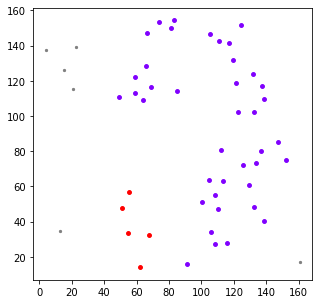

AEC


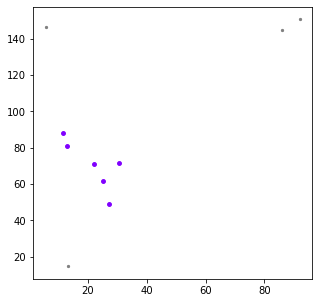

Erythroidpro


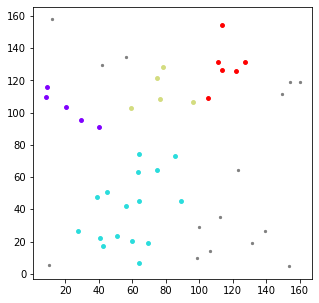

Macrophage


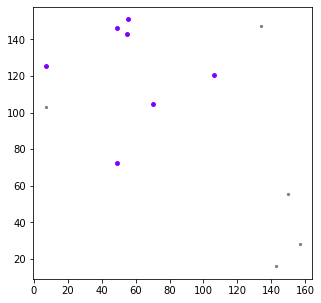

Erythroid


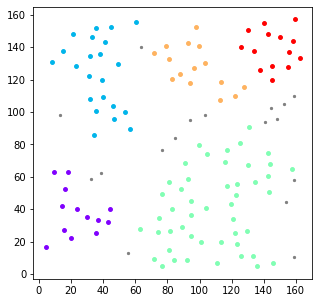

13
Hepatocyte


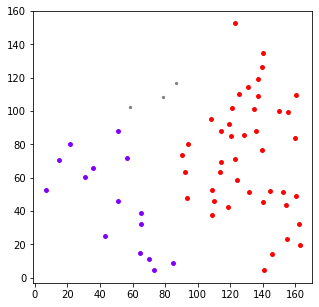

AEC


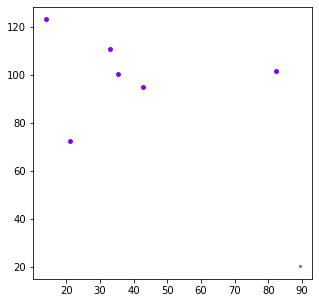

Myeloid


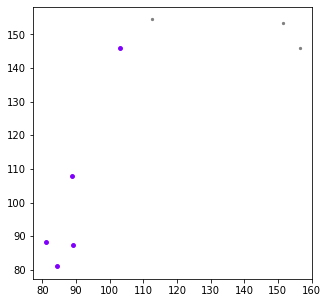

Erythroidpro


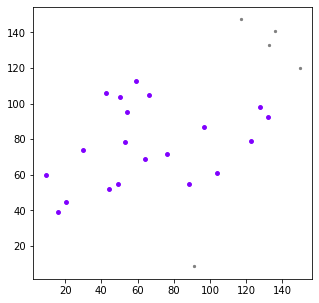

Erythroid


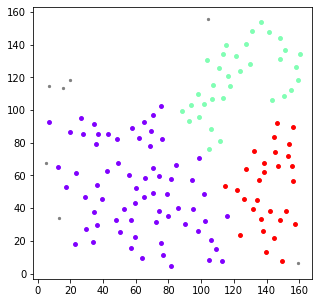

In [109]:
#visualization of DBSCAN clustering result
#for fov in set(meta_df['fov']):
for fov in [9]:
    print(fov)
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']
    
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_type_l = list(set(cluster_df['cell_type']))
    for ct in cell_type_l:
        print(ct)
        plt.figure(figsize=(5,5))
        #plot all ct cells
        meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
        X_sel = np.array(meta_df_sel[['x_positions','y_positions']])
        plt.scatter(X_sel[:,0],X_sel[:,1],c = 'grey',s = 5)
        
        #higlight clusters for ct cells
        tmp_ct = cluster_df[cluster_df['cell_type']==ct]
        colors = cm.rainbow(np.linspace(0, 1, tmp_ct.shape[0]))

        for n,line in enumerate(tmp_ct['cell_idx']):
            X = np.array(meta_df_fov.loc[line][['x_positions','y_positions']])
            plt.scatter(X[:,0],X[:,1],color =colors[n],s = 15)
        plt.savefig(datap+'example/output/Figs/'+group+'_fov_'+str(fov)+"_"+ct+".cluster.pdf", dpi=100, tansparent=True)
        plt.show()

In [220]:
#ot 
#gene expression normalization factor
exp_df_norm = exp_df.iloc[:,2:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.98,axis = 0) 
df_quantile[df_quantile>1]=1

#for fov in set(meta_df['fov']):
for fov in [9]:
    print(fov)
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']
    
    #coordinates
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_id_all = np.array(range(meta_df_fov.shape[0]))
    coord = np.array(meta_df_fov[['x_positions','y_positions']])
    S_all_arr = distance_matrix(coord,coord)
    
    #expression
    exp_df_fov = exp_df[exp_df['fov']==fov].iloc[:,2:]
    exp_df_fov = exp_df_fov/df_quantile
    exp_df_fov.index = cell_id_all

    #select potentially communicating cell cluster pairs (spatially adjacent)
    S_all_arr_new = dbscan_ot.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)

    #optimal transport between source and target cells
    ga_df_final = dbscan_ot.source_target_ot(S_all_arr_new, exp_df_fov, meta_df_fov, known_lr_pairs)
    if ga_df_final.shape[0]>0:
        ga_df_final.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
        ga_df_final.to_csv(datap+'example/output/ot/'+group+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")

        #post-processing of ot results by calculating averaged likelihoods
        ga_df_final['cell_pairs'] = ga_df_final['source_cell_type']+"_"+ga_df_final['target_cell_type']
        final_summary = dbscan_ot.post_ot(ga_df_final,label=group)
        final_summary.to_csv(datap+'example/output/ot/summary/'+group+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")
    

9


[Text(0, 0, 'Kitl_Kit'),
 Text(1, 0, 'Dll1_Notch2'),
 Text(2, 0, 'Jag2_Notch2'),
 Text(3, 0, 'Efnb2_Ephb4'),
 Text(4, 0, 'Dll1_Notch4'),
 Text(5, 0, 'Dll1_Notch3'),
 Text(6, 0, 'Dll4_Notch2'),
 Text(7, 0, 'Dll4_Notch4'),
 Text(8, 0, 'Angpt1_Tek'),
 Text(9, 0, 'Jag2_Notch3'),
 Text(10, 0, 'Dll1_Notch1'),
 Text(11, 0, 'Jag1_Notch2'),
 Text(12, 0, 'Dll4_Notch1'),
 Text(13, 0, 'Jag1_Notch3'),
 Text(14, 0, 'Cd34_Selp'),
 Text(15, 0, 'Jag2_Notch4'),
 Text(16, 0, 'Angpt2_Tek'),
 Text(17, 0, 'Jag2_Notch1'),
 Text(18, 0, 'Jag1_Notch4'),
 Text(19, 0, 'Jag1_Notch1'),
 Text(20, 0, 'Cdh5_Cdh5')]

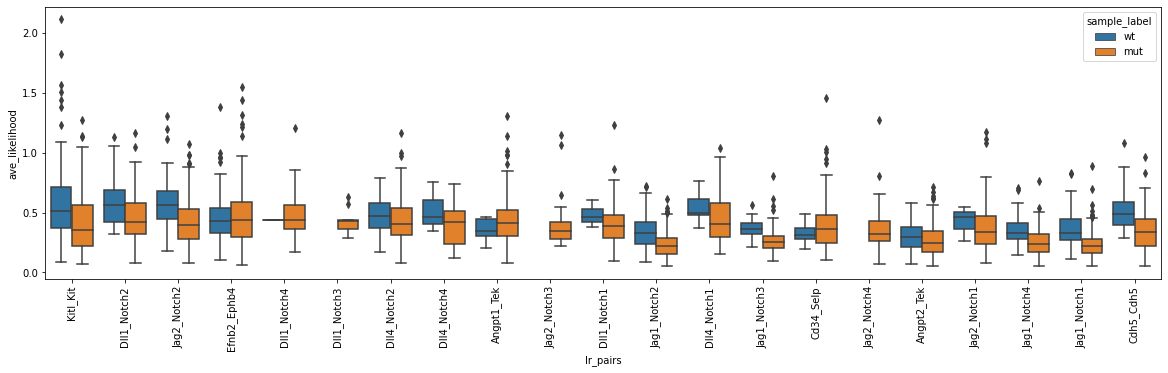

In [196]:
###summarize
c_t_1 = 'Hepatocyte'
c_t_2 = 'Erythroidpro'


df_summary = pd.DataFrame([])
for label in ['wt','mut']:
    for fov in range(21):
        df_summary_tmp = read_data(datap+'example/output/ot/summary/'+label+'_fov_'+str(fov)+".ot.csv")
        if df_summary_tmp.shape[0]>0:
            df_summary = pd.concat([df_summary,df_summary_tmp])
            
df_summary = df_summary[df_summary['ave_likelihood']>0.05]
df_summary['sample_label'] = [x.split("|")[1] for x in df_summary['label']]
df_summary['lr_pairs'] = [x.split("|")[0] for x in  df_summary['label']]
df_summary['cell_pairs'] = [x.split("|")[2] for x in  df_summary['label']]
df_sel = df_summary[df_summary['cell_pairs']==c_t_1+"_"+c_t_2]
order_list = (df_sel.groupby('lr_pairs')['ave_likelihood'].median().sort_values(ascending=False)).index
df_summary_tmp = df_summary.set_index('lr_pairs')
df_summary_tmp = df_summary_tmp.loc[order_list].reset_index()
plt.figure(figsize=(20,5))
ax1 = sns.boxplot(x='lr_pairs',y='ave_likelihood',hue='sample_label',data=df_summary_tmp)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)

In [197]:
#wilcoxon_test
pvalue_dic = {}
statictics_dic = {}
fold_change = {}
#fold_change_mean = {}

likeli_wt = {}
likeli_mut = {}


for lr_pair in list(set(df_sel['lr_pairs'])):
#for lr_pair in ['Kitl_Kit']:
    #print(lr_pair)
    df_sum_fi_sel = df_sel[df_sel['lr_pairs']==lr_pair]
    
    df_ctrl =  df_sum_fi_sel[df_sum_fi_sel['sample_label']=='wt']
    df_ctrl_groupby = df_ctrl.groupby(['label'])['ave_likelihood'].mean()
    df_ctrl_size = df_ctrl.groupby(['label'])['ave_likelihood'].size()
    df_ctrl_size = np.sum([x for x in df_ctrl_size if x <2])
    
    df_mut = df_sum_fi_sel[df_sum_fi_sel['sample_label']=='mut']
    df_mut_groupby = df_mut.groupby(['label'])['ave_likelihood'].mean()
    df_mut_size = df_mut.groupby(['label'])['ave_likelihood'].size()
    df_mut_size = np.sum([x for x in df_mut_size if x <2])
    
    if len(set(df_ctrl['sample_label']))>=1 and len(set(df_mut['sample_label']))>=1 and df_ctrl_size<=1 and df_mut_size<=1:
        
        likeli_mut[lr_pair] = np.mean(df_mut['ave_likelihood'])
        likeli_wt[lr_pair] = np.mean(df_ctrl['ave_likelihood'])
    
        log_fc = np.log10(np.mean(df_mut['ave_likelihood'])/np.mean(df_ctrl['ave_likelihood']))
        fold_change[lr_pair] = log_fc
        pvalue_dic[lr_pair] = ranksums(df_mut['ave_likelihood'],df_ctrl['ave_likelihood'])[1]

p_l = [x if np.isnan(x)==False else 1.0 for x in pvalue_dic.values()]
pvalue_adj = multipletests(p_l, alpha=0.05, method='fdr_bh')[1]

In [198]:
df_summary = pd.DataFrame({'lr_pairs': fold_change.keys(),'lr_likellihood_mut_mean':likeli_mut.values(),\
                           'lr_likellihood_wt_mean':likeli_wt.values(),\
                           'log10_fc':fold_change.values(), 'Wilcoxon': pvalue_dic.values(), 'Wilcoxon_adj_pvalue': pvalue_adj})
df_summary

,lr_pairs,lr_likellihood_mut_mean,lr_likellihood_wt_mean,log10_fc,Wilcoxon,Wilcoxon_adj_pvalue
0,Angpt1_Tek,0.357061,0.370573,-0.016131,1.000000,1.000000
1,Angpt2_Tek,0.221894,0.234695,-0.024359,0.205118,0.622924
2,Kitl_Kit,0.642166,0.823369,-0.107947,0.138477,0.622924
3,Efnb2_Ephb4,0.526677,0.582522,-0.043769,0.482900,0.622924
4,Dll1_Notch4,0.550376,0.435610,0.101561,1.000000,1.000000
5,Dll4_Notch4,0.301572,0.464598,-0.187687,0.317311,0.622924
6,Cdh5_Cdh5,0.143609,0.367533,-0.408116,0.126630,0.622924
7,Jag1_Notch4,0.202165,0.234382,-0.064219,0.527089,0.622924
8,Jag1_Notch1,0.211207,0.146504,0.158859,0.427263,0.622924
9,Jag2_Notch2,0.560546,0.767591,-0.136519,0.185686,0.622924


In [223]:
cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
cluster_df.columns = ['cell_type','cell_idx']
cluster_df

,cell_type,cell_idx


In [245]:
#permutation test
it_n = 20
for fov in set(meta_df['fov']):
#for fov in [9]:
    print(fov)
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']
    
    #coordinates
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_id_all = np.array(range(meta_df_fov.shape[0]))
    coord = np.array(meta_df_fov[['x_positions','y_positions']])
    S_all_arr = distance_matrix(coord,coord)
    
    #expression
    exp_df_fov = exp_df[exp_df['fov']==fov].iloc[:,2:]
    exp_df_fov = exp_df_fov/df_quantile
    exp_df_fov.index = cell_id_all

    #get permutated positions and expression
    random_pos, shuffled_exp = dbscan_ot.permutation_test(coord,int(it_n),random_range=10)

    #select potentially communicating cell cluster pairs (spatially adjacent)
    S_all_arr_new = dbscan_ot.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)
    
    final_summary = pd.DataFrame([])
    for i_n in range(int(it_n)):
        exp_df_permu = exp_df_fov.loc[list(shuffled_exp.iloc[:,i_n])]
        coord_permu = np.array(random_pos.iloc[:,i_n:i_n+2])
        S_all_arr_permu = distance_matrix(coord_permu,coord_permu)
        mask = np.where(S_all_arr_new==np.inf)
        S_all_arr_permu[mask] = np.inf
        S_all_arr_permu = S_all_arr_permu
        
        #optimal transport
        ga_df_permu = dbscan_ot.source_target_ot(S_all_arr_permu, exp_df_permu, meta_df_fov, known_lr_pairs)
        
        if ga_df_permu.shape[0]>0:
            ga_df_permu.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
            ga_df_permu.to_csv(datap+'example/output/permutation/'+group+'_fov_'+str(fov)+".permu.csv",header = True, index = False, sep = "\t")


            #post-processing ot results by calculating averaged likelihoods
            ga_df_permu['cell_pairs'] = ga_df_permu['source_cell_type']+"_"+ga_df_permu['target_cell_type']
            final_summary_tmp = dbscan_ot.post_ot(ga_df_permu, label=group, it_n_label = i_n)
            final_summary = pd.concat([final_summary,final_summary_tmp])
    
    final_summary.to_csv(datap+'example/output/permutation/summary/'+group+'_fov_'+str(fov)+".permu.csv",header = True, index = False, sep = "\t")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [250]:
###########summary for permutation test
it_n = 20
group = 'wt'
group = 'mut'
c_t_1 = 'Hepatocyte'
c_t_2 = 'Erythroidpro'


df_ot = pd.DataFrame([])
df_permu = pd.DataFrame([])

compare_dic ={}
for fov in range(it_n):
    
    #import ot result
    df_ot_tmp = read_data(datap+'example/output/ot/summary/'+label+'_fov_'+str(fov)+".ot.csv")
    if df_summary_tmp.shape[0]>0:
        df_ot = pd.concat([df_ot,df_ot_tmp])
    
    #import permutation result
    df_permu_tmp = read_data(datap+'example/output/permutation/summary/'+group+'_fov_'+str(fov)+".permu.csv")
    if df_permu_tmp.shape[0]>0:
        df_permu = pd.concat([df_permu,df_permu_tmp])
        
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]  

df_permu['it_n'] = [x.split('|')[-1] for x in df_permu['label']]
df_permu['lr_pairs'] = [x.split('|')[0] for x in df_permu['label']]
df_permu['label_new'] = df_permu['lr_pairs']+"|"+df_permu['it_n'].map(str)
df_permu['cell_pairs'] = [x.split('|')[2] for x in df_permu['label']]


c_t_p = c_t_1+"_"+c_t_2
df_ot_tmp = df_ot[df_ot['cell_pairs'] == c_t_p]
df_permu_tmp = df_permu[df_permu['cell_pairs'] == c_t_p]

if df_permu_tmp.shape[0]>0:
    df_ot_groupby = df_ot_tmp.groupby(['label'])['ave_likelihood'].sum().to_frame().reset_index()
    df_ot_groupby.index = [x.split('|')[0] for x in df_ot_groupby['label']]
    df_permu_groupby = df_permu_tmp.groupby(['label_new'])['ave_likelihood'].sum()

    for i in df_ot_groupby.index:
        compare_dic[i+"|"+group+"|"+c_t_p] = 0
        df_permu_groupby_sel = df_permu_groupby[df_permu_groupby.index.str.contains(i+"\|")]
        for j in df_permu_groupby_sel:
            if j > df_ot_groupby.loc[i,'ave_likelihood']:
                compare_dic[i+"|"+group+"|"+c_t_p] += 1/it_n
                        
p_l = [round(x,3) for x in compare_dic.values()]
pvalue_adj = multipletests(p_l, alpha=0.05, method='fdr_bh')[1]
pvalue_adj = [round(x,3) for x in pvalue_adj]

In [251]:
compare_dic

{'Angpt1_Tek|wt|Hepatocyte_Erythroidpro': 0,
 'Angpt2_Tek|wt|Hepatocyte_Erythroidpro': 0,
 'Cd34_Selp|wt|Hepatocyte_Erythroidpro': 0.1,
 'Cdh5_Cdh5|wt|Hepatocyte_Erythroidpro': 0.1,
 'Dll1_Notch1|wt|Hepatocyte_Erythroidpro': 0,
 'Dll1_Notch2|wt|Hepatocyte_Erythroidpro': 0,
 'Dll1_Notch3|wt|Hepatocyte_Erythroidpro': 0,
 'Dll1_Notch4|wt|Hepatocyte_Erythroidpro': 0,
 'Dll4_Notch1|wt|Hepatocyte_Erythroidpro': 0.15000000000000002,
 'Dll4_Notch2|wt|Hepatocyte_Erythroidpro': 0,
 'Dll4_Notch4|wt|Hepatocyte_Erythroidpro': 0.15000000000000002,
 'Efnb2_Ephb4|wt|Hepatocyte_Erythroidpro': 0,
 'Jag1_Notch1|wt|Hepatocyte_Erythroidpro': 0,
 'Jag1_Notch2|wt|Hepatocyte_Erythroidpro': 0,
 'Jag1_Notch3|wt|Hepatocyte_Erythroidpro': 0,
 'Jag1_Notch4|wt|Hepatocyte_Erythroidpro': 0,
 'Jag2_Notch1|wt|Hepatocyte_Erythroidpro': 0,
 'Jag2_Notch2|wt|Hepatocyte_Erythroidpro': 0,
 'Jag2_Notch3|wt|Hepatocyte_Erythroidpro': 0,
 'Jag2_Notch4|wt|Hepatocyte_Erythroidpro': 0,
 'Kitl_Kit|wt|Hepatocyte_Erythroidpro': 0}